# Chapter 3: Least Mean Square

## Imports 

In [1]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../Sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import LMS
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Exercise 2

### (a) Compute de Wiener Solution

$x(k) = -0.85x(k-1)+n(k) = -ax(k-1)+n(k)$

Assuming x(k) is WSS and according to example 2.4.b,

$r(l) = \frac{(-a)^{|l|}}{1-a^2}$ 

Therefore, 

$r(0) = \frac{(-0.85)^{|0|}}{1-(0.85)^2}\sigma_n^2$

$r(1) = \frac{(-0.85)^{|1|}}{1-(0.85)^2}\sigma_n^2$

Since $N = 2$ (first-order filter), 

$ R = 
\begin{bmatrix} 
r(0) & r(1) \\
r(1) & r(0) 
\end{bmatrix} 
= 
\begin{bmatrix} 
1.08 & -0.92 \\
-0.92 & 1.08
\end{bmatrix} \rightarrow R^{-1} = 
\begin{bmatrix} 
    3.33 & 2.83 \\
    2.83 & 3.33
\end{bmatrix}
$

Assuming the desired signal is $d(k) = \textbf{x}(k+L)$

$p = \begin{bmatrix} 
    E[d(k)\textbf{x}[k]\\
    E[d(k)\textbf{x}[k-1]
\end{bmatrix} = 
\begin{bmatrix} 
    E[x(k+L)\textbf{x}(k)\\
    E[x(k+L)\textbf{x}(k-1)
\end{bmatrix} = 
\begin{bmatrix} 
    r(L) \\
    r(L+1)
\end{bmatrix} 
$

For $L = 1$ 

$\textbf{p} = [-0.92, 0.78]^T$
    
Finally, the Wiener solution is 

$\textbf{w}_o = \textbf{R}^{-1}\textbf{p} = [-0.85, 0]^T$

In [2]:
L = 1 # Future lag
sigma_n2 = .3      # noise power
r = lambda l, a: ((-a)**(abs(l))/(1-(a)**2))*sigma_n2
R = [[r(0, 0.85), r(1, 0.85)], [r(1, 0.85), r(0, 0.85)]]
print ('R: ', R)
R_inv = np.linalg.inv(R)
print ('R_inv: ', R_inv)
p = [r(0+L, 0.85), r(1+L, 0.85)]
print ('p: ', p)
w_o = np.dot(R_inv, p)
print ('w_o: ', w_o)

R:  [[1.0810810810810807, -0.9189189189189185], [-0.9189189189189185, 1.0810810810810807]]
R_inv:  [[3.33333333 2.83333333]
 [2.83333333 3.33333333]]
p:  [-0.9189189189189185, 0.7810810810810808]
w_o:  [-0.85  0.  ]


### (b) Choose an appropriate value for $\mu$ and plot the convergence path for the LMS algorithm on the MSE error surface.

In order to satisfy both convergence and low variance on steady-state, 

$0 < \mu < \frac{1}{tr[R]} = 1.85$

By making $\mu = 0.99\frac{1}{tr[R]}$ we have

In [3]:
print ('tr[R] = ', 1/np.trace(R))
mu = 0.99*1/np.trace(R) # Convergence factor (step) (0 < mu < 1)
print ('mu = ', mu)

tr[R] =  0.4625000000000002
mu =  0.45787500000000014


In [4]:
K = 100             # number of iterations (signal length)
H = np.array([-0.85, 1])    
w_o = np.dot( np.linalg.inv(R), p)             # Unknown system
N = 2               # Number of coefficients of the adaptive filter     
output_filepath = './Outputs/Exercise_1/'


In [5]:
d = np.zeros([K]) # Desired signal
x = np.zeros([K+L])

n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K+L)) # Noise signal
for k in np.arange(1, K):
    x[k] = -0.85*x[k-1] + n[k]

prefixed_x = np.append(np.zeros([N-1]), x)
X_tapped = rolling_window(prefixed_x, N)    
    
for k in np.arange(K):        
    d[k] = np.dot(np.conj(w_o), X_tapped[k])
    
init_coef = np.ones([N]) 
filter_order = N-1    

lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
lms.fit(d, x[:k+1])    

print (lms)

LMS(step=0.45787500000000014, filter_order=1)


Plotting MSE Error Surface

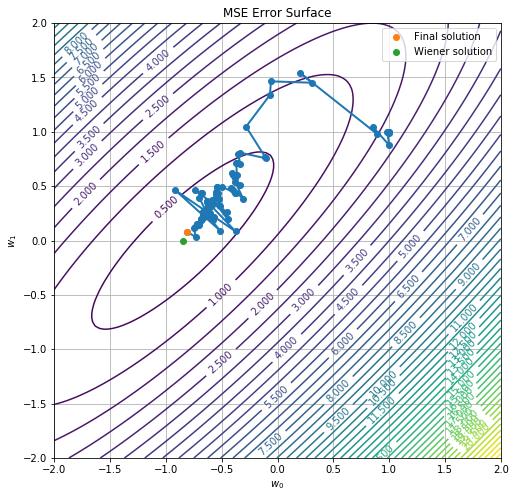

In [10]:
def get_mse_error(w, p, R):
    return r(0, 0.85)-2*np.dot(w,p)+np.dot(np.matmul(w,R), w)

w_0, w_1 = np.linspace(-2,2,100), np.linspace(-2,2,100)
MSE_error = np.zeros([w_0.shape[0], w_1.shape[0]])

for i, w_i in enumerate(w_0):
    for j, w_j in enumerate(w_1):
        MSE_error[i][j] = get_mse_error([w_j, w_i], p, R)

coef = np.real(lms.coef_vector)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.plot(coef[:,0], coef[:,1], '-o', linewidth=2)
ax.plot(coef[-1,0], coef[-1,1], 'o', label='Final solution')
ax.plot(w_o[0], w_o[1], 'o', label='Wiener solution')
cs = ax.contour(w_0, w_1, MSE_error, levels=np.arange(0, np.max(MSE_error), 0.5))
ax.clabel(cs, cs.levels)
ax.set_xlabel('$w_0$'), ax.set_ylabel('$w_1$'), ax.set_title('MSE Error Surface')
ax.grid(True)
ax.legend()
if output_filepath is not None:        
    fig.savefig(output_filepath + 'b_convergence_path.jpg', bbox_inches = 'tight')

### (c) Plot the learning curves for the MSE and the iteration coeficients in a single run as well as for the average of 25 runs.

In [13]:
n_ensembles = 25   # number of realizations within the ensemble
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal
    x = np.zeros([K+L])

    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K+L)) # Noise signal
    for k in np.arange(1, K):
        x[k] = -0.85*x[k-1] + n[k]

    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)        
        
    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k])

    init_coef = np.ones([N])     
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x[:k+1])     

    W[ensemble] = np.real(lms.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(lms.error_vector)**2)
    MSE_min[ensemble] = MSE_min[ensemble] + np.real(np.absolute(n[:k+1])**2)

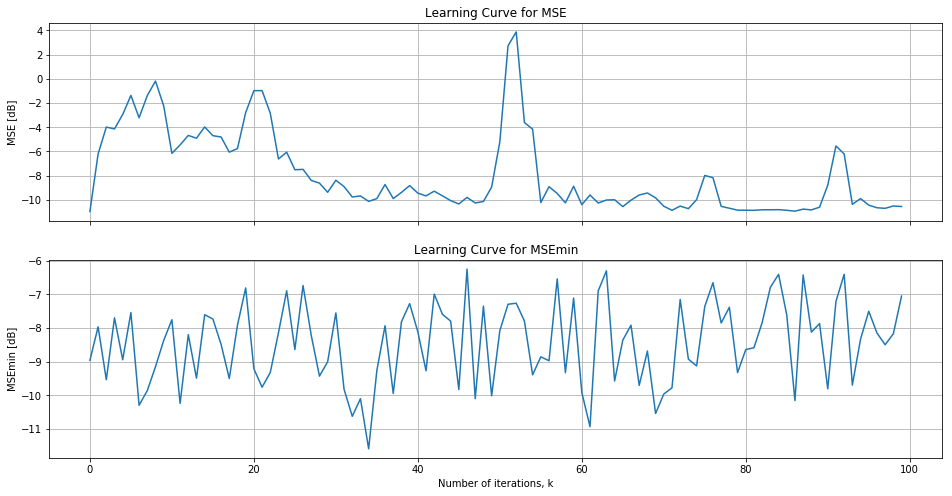

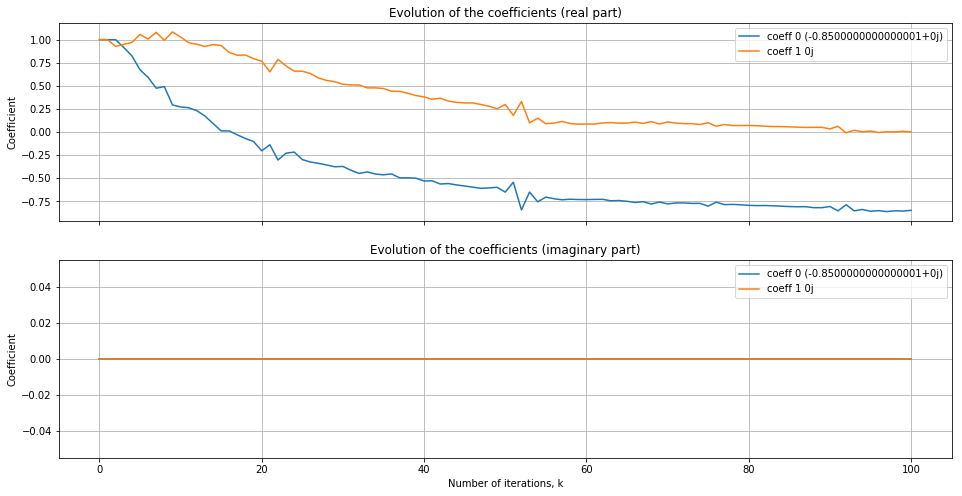

In [14]:
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS')

## Exercise 7

$x(k) = n_1(k), \sigma_x^2 = 1.0$

$n(k)$ with $\sigma_n^2 = 10^{-3}$

$N = 12$ coefficients


### (a) Calculate the upper bound for $\mu (\mu_{max})$ to guarantee the algorithm stability.

$ r(l) = E[x(k)x(k-l)] = E[n_1(k)n_1(k-l)] = \sigma_x^2 \delta (l)$

$R = \sigma_x^2 I_{N\times N} \rightarrow R^{-1} = \frac{1}{\sigma_x^2} I_{N\times N}$

$0 < \mu < \frac{1}{\lambda_{max}} = \sigma_x^2 = 1$


In [110]:
N = 8+1  # Number of coefficients in the adaptive filter
output_filepath = './Outputs/Exercise_7/'
output_filepath = './Outputs/Exercise_8/'
sigma_x = 1
sigma_n = 10e-3
R = sigma_x*np.eye(N)
mu_max = np.max(np.linalg.eigvals(R))

### (b) Run the algorithm for $\mu_{max}/2$, $\mu_{max}/10$  and $\mu_{max}/50$. Comment on the convergence behavior in each case.

$\frac{D(z)}{X{z}} = H(z) = \frac{1-z^{-12}}{1-z^{-1}}$

\begin{equation*}
    d(k) = d(k-1) + x(k) - x(k-12) = d(k-1) + n_1(k) - n_1(k-12) \\
    d'(k) = d(k) + n(k) = d(k-1)+n_1(k) - n_1(k-12) + n(k)
\end{equation*} The scheme is an ARMA process

\begin{equation*}
    p(l) = E[d'(k)x(k-l)] \\    
    = E[(d(k)+n(k))x(k-l)] \\
    = E[d(k)x(k-l) + n(k)x(k-l)] \\
    = E[d(k)n_1(k-l) + n(k)n_1(k-l)] \\
    = E[d(k)n_1(k-l)] + E[n(k)n_1(k-l)]
    = E[(d(k-1)+n_1(k)-n_1(k-12))n_1(k-l)] + 0\\
    = E[d(k-1)n_1(k-l)+n_1(k)n_1(k-l)-n_1(k-12)n_1(k-l)] \\    
    = E[d(k-1)n_1(k-l)]+E[n_1(k)n_1(k-l)]-E[n_1(k-12)n_1(k-l)] \\
    = E[d(k-1)n_1(k-l)] + \sigma_x^2\delta (l) - \sigma_x^2 \delta(l-12) \\
    = p(l-1) + \sigma_x^2\delta (l) - \sigma_x^2 \delta(l-12) 
\end{equation*} with p(-1) = 0




In [111]:
dirac = lambda l: 1 if l == 0 else 0
p_func = lambda l: 0 if l < 0 else p_func(l-1) + dirac(l)-dirac(l-12)
p = np.array([p_func(l) for l in np.arange(N)])
R_inv = np.linalg.inv(R)
w_o = np.dot(R_inv, p)
w_o

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

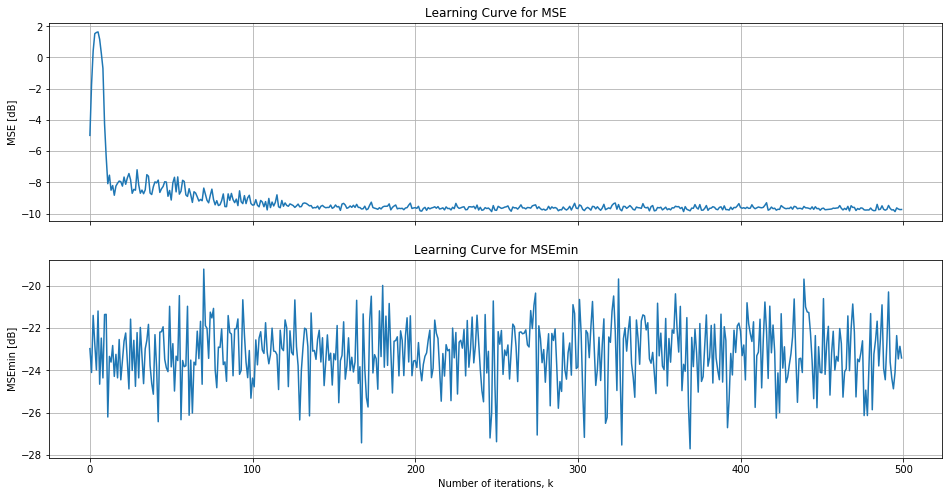

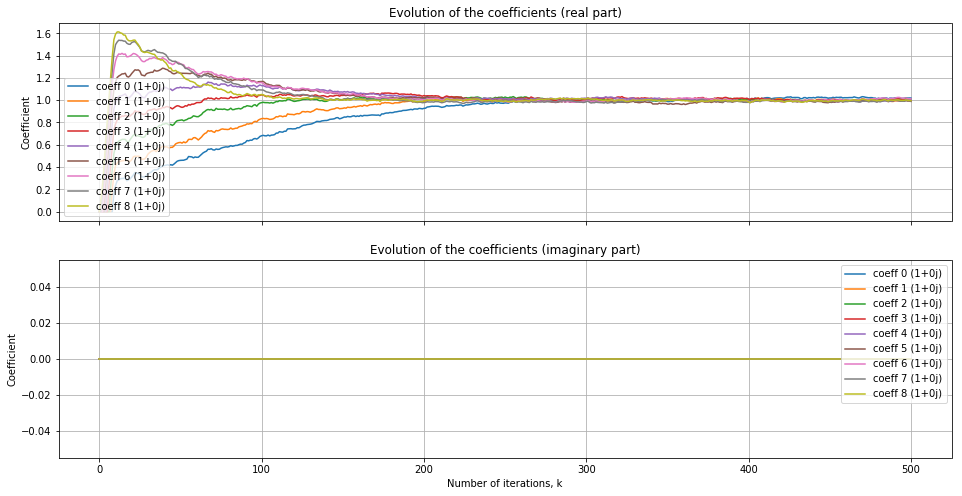

In [112]:
# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
n_ensembles = 20   # number of realizations within the ensemble
K = 500   # number of iterations (signal length)
W = np.ones([n_ensembles, K+1, N], dtype=complex) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
div = 2
mu = mu_max/div

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal
    n = np.sqrt(sigma_n/2)*(np.random.normal(size=K)) # Noise signal
    x = np.sqrt(sigma_x/2)*(np.random.uniform(size=K))

    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)    

    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k]) + n[k]

    init_coef = np.zeros([N]) 
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x)        

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS_mu_' + str(div)) 
    

### (c) Measure the misadjustment in each example and compare with the results obtained by (3.50).

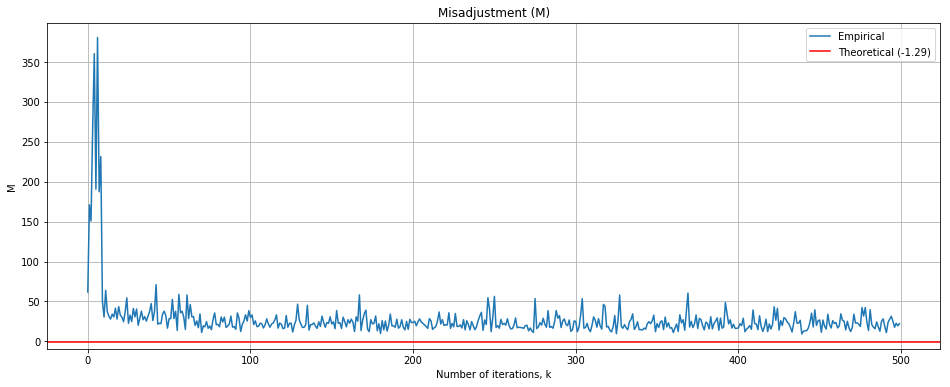

In [113]:
m_theoretical = mu*np.trace(R)/(1-mu*np.trace(R))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot((MSE_av-MSEmin_av)/MSEmin_av, label='Empirical')
ax.axhline(m_theoretical, color='r', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment.jpg', bbox_inches = 'tight')

### (d) Plot the obtained FIR filter frequency response at any iteration after convergence is achieved and compare with the unknown system.

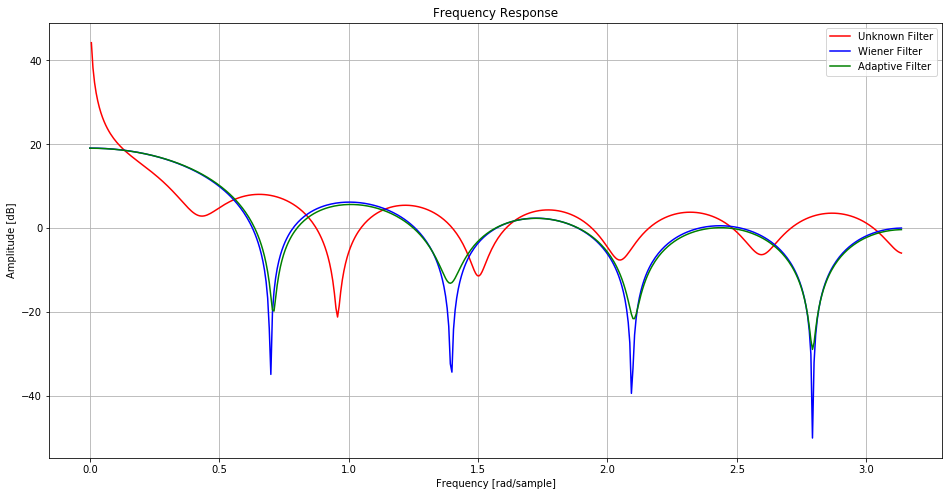

In [114]:
b, a = [1, -1] + list(np.zeros(10)) + [-1], [1, -1]
wf_lms, h_lms = signal.freqz(lms.coef_vector[-1])
wf_o, h_o = signal.freqz(w_o)
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_o, 20 * np.log10(abs(h_o)), 'b', label='Wiener Filter')
ax.plot(wf_lms, 20 * np.log10(abs(h_lms)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response.jpg', bbox_inches = 'tight')

______________
# Exercise 8

Repeat the previous problem using an adaptive filter with eight coefficients and
interpret the results.

____________________
# Exercise 10

$h(k) = k u(k)-(2k-9)u(k-5) + (k-9)u(k-10)$
\begin{equation*}
    h(k) = k u(k)-(2k-9)u(k-5) + (k-9)u(k-10) \\
    = ku(k)-(2k-10+1)u(k-5)+(k-10+1)u(k-10) \\
    = ku(k)-2(k-5)u(k-5)-u(k-5)+(k-10)u(k-10)+u(k-10)
\end{equation*} Taking the Z transform we have 

\begin{equation*}
    H(z) = \frac{z}{(z-1)^2}-2\frac{z}{(z-1)^2}z^{-5}-\frac{z}{z-1}z^{-5}+\frac{z}{(z-1)^2}z^{-10}+\frac{z}{z-1}z^{-10} \\
    = \frac{z}{(z-1)^2}-2\frac{z}{(z-1)^2}z^{-5}-\frac{z(z-1)}{(z-1)^2}z^{-5}+\frac{z}{(z-1)^2}z^{-10}+\frac{z(z-1)}{(z-1)^2}z^{-10} \\
    = \frac{z}{(z-1)^2}[1-2z^{-5}-(z-1)z^{-5}+z^{-10}+(z-1)z^{-10}] \\
    = \frac{z}{z^2-2z+1}[1-z^{-5}-z^{-4}+z^{-9}] \\
    = \frac{z^{-1}-z^{-6}-z^{-5}+z^{-10}}{1-2z^{-1}+z^{-2}} 
\end{equation*}


$x(k) = sign(n(k))$

$n(k)$ with $\sigma_n = 10^{-2}$

In [138]:
output_filepath = './Outputs/Exercise_10/'
b = [0, 1, 0, 0, 0, -1, -1, 0, 0, 0, 1]
a = [1, -2, 1]
H = np.array(b+a)
w_o = H
K = 500
N = 100
mu = .1
sigma_n = 10e-2

# impulse response function
h_10 = lambda k: k*np.heaviside(k, 1)-(2*k-9)*np.heaviside(k-5, 1)+(k-9)*np.heaviside(k-10, 1)

In [152]:
# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal

    # Creating the input signal (normalized)        
    x = np.sign(np.random.randn(K)) # Input Signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Complex noise

    # Creating a tapped version of x with a N-sized window 
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, len(w_o))

#     for k in np.arange(K):        
#         d[k] = np.dot(np.conj(w_o), X_tapped[k])+n[k]       
    H = [h_10(k) for k in np.arange(-int(K/2), int(K/2)-1, 1)]
    d = np.convolve(x, H, 'same') + n

    init_coef = W[ensemble][0]
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x)     

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2



/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


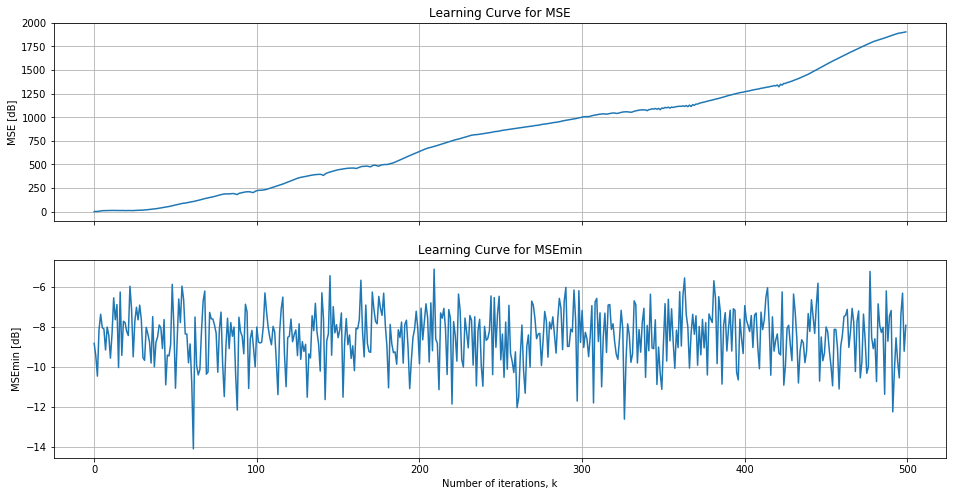

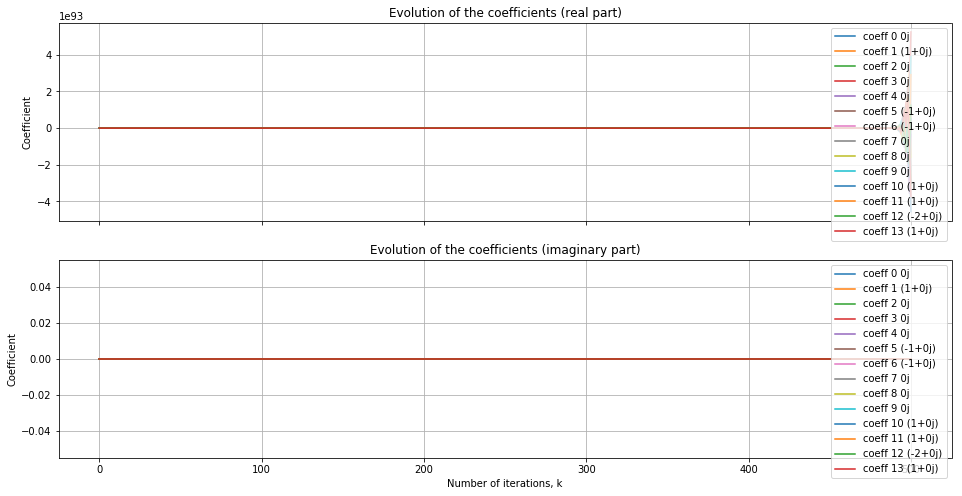

In [153]:
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, len(w_o), MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='10a_LMS')

### (b) Convolve one of the equalizer’s impulse response after convergence with the channel impulse response and comment on the result.

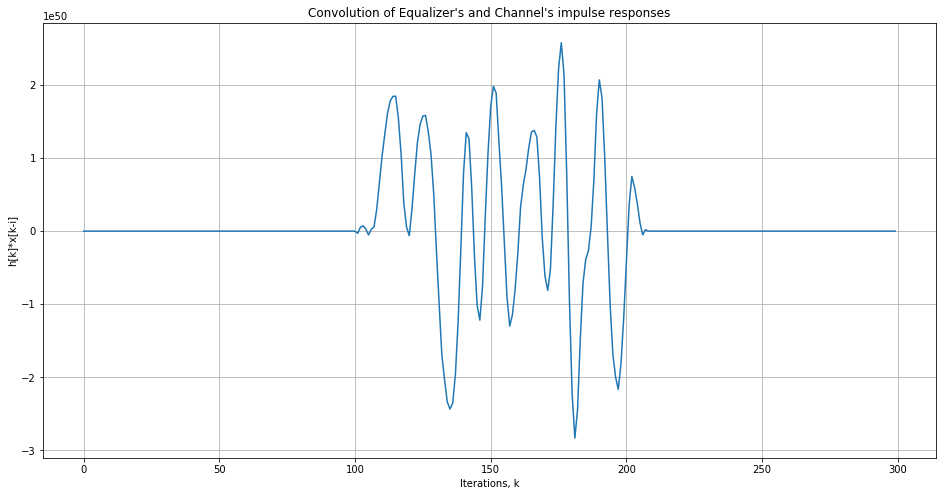

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16,8))
ax.plot(np.convolve(H, np.real(lms.coef_vector[-1])), '-')
ax.set_xlabel('Iterations, k'), ax.set_ylabel('h[k]*x[k-i]')
ax.set_title("Convolution of Equalizer's and Channel's impulse responses")
ax.grid(True)

________
## Exercise 26

In [ ]:
## Definitions
n_ensembles = 20   # number of realizations within the ensemble
K = 100             # number of iterations (signal length)
H = np.array([0.32+0.21j,-0.3+0.7j,0.5-0.8j,0.2+0.5j])    
w_o = H             # Unknown system
sigma_n2 = .4      # noise power
N = 4               # Number of coefficients of the adaptive filter
mu = .1            # Convergence factor (step) (0 < mu < 1)
output_filepath = './Outputs/Exercise_26/'


In [ ]:
## Definitions
j = complex(0,1)
n_ensembles = 100   # number of realizations within the ensemble
K = 100             # number of iterations (signal length)
H = np.array([0.32+0.21j,-0.3+0.7j,0.5-0.8j,0.2+0.5j])    
w_o = H             # Unknown system
sigma_n2 = .04      # noise power
N = 4               # Number of coefficients of the adaptive filter
mu = .1            # Convergence factor (step) (0 < mu < 1)

## Computing 

# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
W = np.ones([n_ensembles, K+1, N], dtype=complex) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K], dtype=complex) # Desired signal

    # Creating the input signal (normalized)        
    x = (np.sign(np.random.randn(K)) + j*np.sign(np.random.randn(K)))/np.sqrt(2) # Complex signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)+j*np.random.normal(size=K)) # Complex noise
    sigma_x2 = np.var(x) # signal power = 1

    # Creating a tapped version of x with a N-sized window 
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)

    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k])+n[k]       

    init_coef = W[ensemble][0]
    filter_order = N-1    

    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x)     

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS')

In [ ]:
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='LMS')